# THESIS - Model 

# Imports 

In [4]:
#imports

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import shlex, subprocess
import os , sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from Bio import SeqIO
import time

# 1. Preparation of the dataset 
- One hot encoding the sequences 

In [5]:
#One-hot encoding 

#for every fasta sequence, encode and maybe add to a list (?) --> now trying to add everything to an array --> eventually in a matrix
def onehotencode(seq) : 
    values = list(seq)
    values = np.array(values)
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    if np.shape(onehot_encoded) == (400,3): #this is a problem, I'm just adding a column at the end but how can I know if that zeros column is in the right place? 
        col = np.zeros([400,1])
        onehot_encoded = np.column_stack((onehot_encoded,col))
        
    return onehot_encoded

In [6]:
_start_time = time.time()
#change a bit this function or cite 
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [7]:
#dataset upload, keeping the first four folders for training and testing and the last one for validation --> try with matrices not list

#/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/AARS_K562/fold-0/
from Bio import SeqIO
path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)


tic()

for folder in directory1:

    if folder == 'AARS_K562': #to be removed later 
        directory2 = os.listdir(path + '/' + folder)
        seq_list_positive = np.zeros((1,400,4)) 
        seq_list_negative = np.zeros((1,400,4)) 
        seq_list_positive_val = np.zeros((1,400,4)) 
        seq_list_negative_val = np.zeros((1,400,4)) 
        
        for folder2 in directory2 :
            directory3 = os.listdir(path+ '/' + folder + '/' + folder2)
            
            if folder2 != "fold-4":
            
                seq_list_positive_file = np.zeros((1,400,4)) 
                seq_list_negative_file = np.zeros((1,400,4)) 

                for file in directory3 :

                    if "fasta" in file :
                        fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                        seq_array = np.zeros((1,400,4)) 

                        for fasta in fasta_sequences:
                            name, sequence = fasta.id, str(fasta.seq)
                            new_sequence = onehotencode(sequence)
                            new_sequence = np.expand_dims(new_sequence, axis =0)
                            seq_array = np.vstack((seq_array,new_sequence))
                        seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
            
                        
                        if "positive" in file : 
                            seq_list_positive_file = np.vstack((seq_list_positive_file, seq_array))


                        if "negative-1" in file: # 2 neg: 1 pos with 'negative' --> 1 neg : 1 pos 'negative-1'
                            seq_list_negative_file = np.vstack((seq_list_negative_file, seq_array))
                            
                seq_list_negative_file = np.delete(seq_list_negative_file, 0, 0)
                seq_list_positive_file = np.delete(seq_list_positive_file, 0, 0)

                seq_list_positive = np.vstack((seq_list_positive, seq_list_positive_file))
                seq_list_negative = np.vstack((seq_list_negative, seq_list_negative_file))

  
                
            if folder2 == "fold-4":
                     
                    seq_list_positive_val_file = np.zeros((1,400,4)) 
                    seq_list_negative_val_file = np.zeros((1,400,4)) 

                    for file in directory3 :

                        if "fasta" in file :
                            fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                            seq_array = np.zeros((1,400,4)) 

                            for fasta in fasta_sequences:
                                name, sequence = fasta.id, str(fasta.seq)
                                new_sequence = onehotencode(sequence)
                                new_sequence = np.expand_dims(new_sequence, axis =0)
                                seq_array = np.vstack((seq_array,new_sequence))
                            seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 7

                            if "positive" in file : 
                                seq_list_positive_val_file = np.vstack((seq_list_positive_val_file, seq_array))
 

                            if "negative-1" in file: 
                                seq_list_negative_val_file = np.vstack((seq_list_negative_val_file, seq_array))
 
                    seq_list_negative_val_file = np.delete(seq_list_negative_val_file, 0, 0)
                    seq_list_positive_val_file = np.delete(seq_list_positive_val_file, 0, 0)

                    seq_list_positive_val = np.vstack((seq_list_positive_val, seq_list_positive_val_file))
                    seq_list_negative_val = np.vstack((seq_list_negative_val, seq_list_negative_val_file))
    
                    seq_list_negative_val = np.delete(seq_list_negative_val, 0, 0)
                    seq_list_positive_val = np.delete(seq_list_positive_val, 0, 0)  

        
                  
        seq_list_negative = np.delete(seq_list_negative, 0, 0)
        seq_list_positive = np.delete(seq_list_positive, 0, 0)

        


            
tac()


Time passed: 0hour:0min:15sec


- Preparation of the labels 

In [10]:
#preparation of the labels for the positive and negative dataset and validation set

labels_positive = np.ones((np.shape(seq_list_positive)[0], 1))

labels_negative = np.zeros((np.shape(seq_list_negative)[0], 1))
 
labels_positive_val = np.ones((np.shape(seq_list_positive_val)[0], 1))

labels_negative_val = np.zeros((np.shape(seq_list_negative_val)[0], 1))
print('Shape of labels: \n-positive : ',np.shape(labels_negative),'\n-negative : ', np.shape(labels_negative),'\n-positive validation : ',np.shape(labels_positive_val),'\n-negative validation : ',np.shape(labels_negative_val))

Shape of labels: 
-positive :  (2667, 1) 
-negative :  (2667, 1) 
-positive validation :  (720, 1) 
-negative validation :  (720, 1)


In [11]:
#merging the positive and negative datasets 
x = np.vstack((seq_list_positive, seq_list_negative))

x_val = np.vstack((seq_list_positive_val, seq_list_negative_val))

y = np.vstack((labels_positive, labels_negative))

y_val = np.vstack((labels_positive_val, labels_negative_val))


- Splitting of the dataset : test, train and validation sets 

In [12]:
#creation of the testing set 
import numpy as np
from sklearn.model_selection import train_test_split

#parameters 
test_size1 = 0.33

#test set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size1, shuffle= True)

y_train = y_train.astype("float32")#actually useful?
y_test = y_test.astype("float32")
x_train = x_train.astype("float32")
x_test =x_test.astype("float32")

x_val = x_val.astype("float32")
y_val =y_val.astype("float32")

print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-testing set : ', np.shape(x_test),'\n-validation set : ',np.shape(x_val))

Shape of datasets: 
-training set :  (3573, 400, 4) 
-testing set :  (1761, 400, 4) 
-validation set :  (1440, 400, 4)


In [ ]:
# Prepare the training dataset. --> I HAVE AVOIDED THIS STEP OTHERWISE THE MODEL DOES NOT RUN 
#parameters
batch_size = 32 #--> how much should be my batch size? 
buffer_size = len(x_train) + 100 #For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
buffer_size_test= len(x_test) + 100

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size) 

# Prepare the testing dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size=buffer_size_test).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

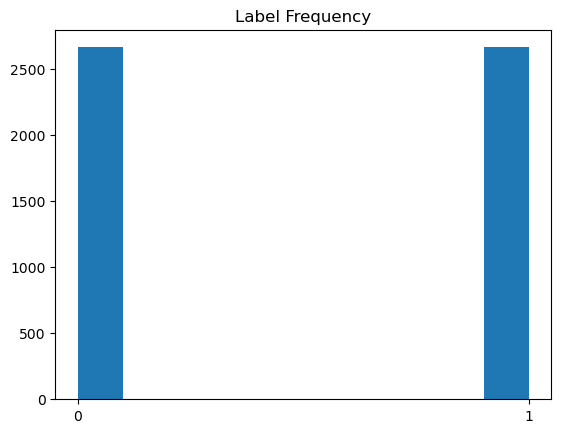

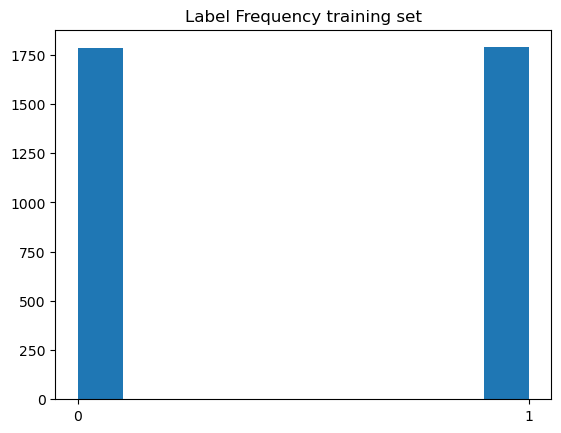

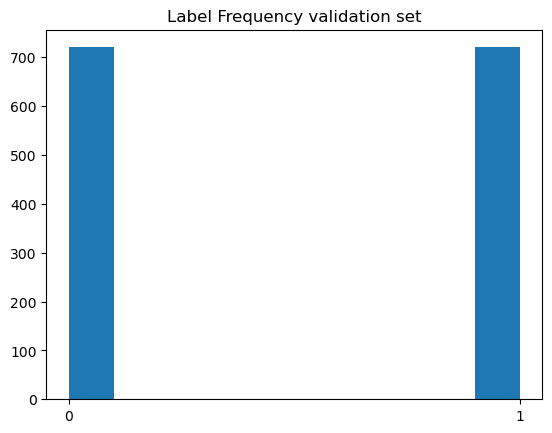

In [13]:
#checking class ditribution in the whole dataset and training set
import matplotlib.pyplot as plt

plt.hist(y)
plt.xticks(range(2))
plt.title('Label Frequency')
plt.show()

plt.hist(y_train)
plt.xticks(range(2))
plt.title('Label Frequency training set')
plt.show()

plt.hist(y_val)
plt.xticks(range(2))
plt.title('Label Frequency validation set')
plt.show()

# 2. Model  

# 2.1 .compile() 
- Create the baseline model 

In [16]:
#first is .compile() --> to create the baseline model : no dataset
def create_baseline():
    from tensorflow.keras.optimizers.legacy import Adam
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (400, 4)
    #batch_size = 1 --> when batching the dataset, the model gives a graph error 
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape= input_shape))#, batch_size=batch_size))
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer=tf.keras.initializers.constant(1), #to be changed once I have the actual input data
             #glorot_uniform(seed=12)
              activation='relu'))#,input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer=tf.keras.initializers.constant(1), 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters

    #model.add(keras.layers.Dense(4, activation='relu'))#is it always relu? also sigmoid is an option 
    #model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # for binary classification
    
    #model.compile( optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),# Optimizer
                    # Loss function to minimize
                    #loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    #metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model


In [17]:
model = create_baseline()

print(model.layers)

print(model.summary()) 

2023-02-06 18:29:23.786159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 18:29:23.802314: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 18:29:23.802975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (csix012272600ser.scidom.de): /proc/driver/nvidia/version does not exist
2023-02-06 18:29:23.835258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[<keras.layers.convolutional.conv1d.Conv1D object at 0x7f27047bd330>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7f27047bd5d0>, <keras.layers.regularization.dropout.Dropout object at 0x7f27047bf4f0>, <keras.layers.convolutional.conv1d.Conv1D object at 0x7f27048234c0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7f27046d31c0>, <keras.layers.regularization.dropout.Dropout object at 0x7f27048239a0>, <keras.layers.reshaping.flatten.Flatten object at 0x7f27046d34c0>, <keras.layers.core.dense.Dense object at 0x7f27046d25c0>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 376, 30)           3030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 188, 30)          0         
 )                                                               
                        

# 2.2 .fit() 
- Training the model 

In [22]:
%load_ext tensorboard
%rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 118890), started 0:52:08 ago. (Use '!kill 118890' to kill it.)

In [24]:
#second is to use .fit() --> to train the model : use x_train, y_train --> either .fit() or training loop from scratch (see below)
print("Fit model on training data")
import datetime
#%tensorboard --logdir logs/fit
#parameters 
#batch_size=32
epochs= 20

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    #batch_size=batch_size, --> the tf.dataset already batched the dataset 
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_test,y_test),
    callbacks=[tensorboard_callback]
)

Fit model on training data
Epoch 1/20
112/112 [==============================] - 4s 20ms/step - loss: 7323.4961 - accuracy: 0.4923 - val_loss: 176.6767 - val_accuracy: 0.5009
Epoch 2/20
112/112 [==============================] - 1s 11ms/step - loss: 5537.8735 - accuracy: 0.5029 - val_loss: 2915.8228 - val_accuracy: 0.5009
Epoch 3/20
112/112 [==============================] - 1s 10ms/step - loss: 5175.9233 - accuracy: 0.4968 - val_loss: 284.8226 - val_accuracy: 0.4991
Epoch 4/20
112/112 [==============================] - 1s 10ms/step - loss: 3663.1853 - accuracy: 0.4892 - val_loss: 1118.7821 - val_accuracy: 0.4991
Epoch 5/20
112/112 [==============================] - 1s 10ms/step - loss: 3025.0630 - accuracy: 0.4979 - val_loss: 3622.1599 - val_accuracy: 0.4991
Epoch 6/20
112/112 [==============================] - 1s 10ms/step - loss: 2155.6260 - accuracy: 0.5108 - val_loss: 106.1425 - val_accuracy: 0.5009
Epoch 7/20
112/112 [==============================] - 1s 10ms/step - loss: 1818.43

In [25]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 118890), started 0:53:20 ago. (Use '!kill 118890' to kill it.)

In [26]:
#first attempt of a training loop from scratch --> added the evaluation loop here --> WORKS WITH TF.DATASETS

#parameters
#input_shape = (3388, 401, 4)
input_shape = (400, 4)
epochs = 5 #for the test 
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)#parameter is recommended as true 
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()


model = create_baseline()

import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #55 steps
        #print(step)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  
            #print("Number of weights after calling the model:", len(model.weights))

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
    
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
    

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) #I think it doesn't work because there's just one class now . 

        # Log every 200 batches.
        if (step % 50) == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)

        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    


Start of epoch 0


NameError: name 'train_dataset' is not defined